# Ensemble

Todo:

- Remove max evals here - it doesn't work
- Fix dates in plotting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

from datetime import datetime, timedelta

from nb_utils import train_eval_plot_ensemble

In [3]:
with open('../config/sample_homogeneous_train_config.json') as f_train, \
    open('../config/sample_homogeneous_test_config.json') as f_test, \
    open('../config/sample_homogeneous_forecast_config.json') as f_forecast:
    default_train_config = json.load(f_train)
    default_test_config = json.load(f_test)
    default_forecast_config = json.load(f_forecast)

In [4]:
model_class = 'homogeneous_ensemble'
default_train_config['model_class'] = model_class
default_test_config['model_class'] = model_class
default_forecast_config['model_class'] = model_class

In [5]:
current_day = datetime.now().date() - timedelta(4) # Forecast starts from the day after current day
forecast_length = 30 # Length of forecast interval (days)

### Inputs to train-eval-plot

In [6]:
region = 'bengaluru urban'
region_type = 'district'

current_day = datetime.now().date() - timedelta(23)
forecast_length = 30

name_prefix = region

In [7]:
default_forecast_config

{'data_source': '',
 'region_name': [],
 'region_type': '',
 'run_day': '',
 'forecast_start_date': '',
 'forecast_end_date': '',
 'model_class': 'homogeneous_ensemble',
 'forecast_variables': ['confirmed', 'recovered', 'deceased'],
 'model_parameters': {'child_model': {'model_class': 'SEIHRD',
   'model_parameters': {'incubation_period': 5, 'F_icu': 0.05}},
  'modes': {'training_mode': 'constituent_models',
   'predict_mode': 'mean_predictions'},
  'constituent_models': {'0': {'model_class': 'SEIHRD',
    'model_parameters': {'incubation_period': 5,
     'F_icu': 0.05,
     'EbyCRatio': 28.16604550441872,
     'F_fatalities': 0.02466701801276612,
     'F_hospitalization': 0.06963507606419204,
     'IbyCRatio': 1.4785269422997283,
     'infectious_period': 5.42824969419175,
     'r0': 2.0045875407735303,
     'LatentEbyCRatio': {'5/27/20': 28.16604550441872,
      '6/3/20': 1.6812382970858852},
     'LatentIbyCRatio': {'5/27/20': 1.4785269422997283,
      '6/3/20': 0.26879511010742685}

### Train eval plot

{'max_evals': 10}
t = 7.90                                              
t = 7.90                                              
t = 7.90                                                                        
t = 7.90                                                                      
t = 7.90                                                                      
t = 7.90                                                                      
t = 7.90                                                                      
t = 7.90                                                                      
t = 7.90                                                                      
t = 7.90                                                                      
100%|██████████| 10/10 [00:00<00:00, 10.33trial/s, best loss: 97.2028386854295]
t = 7.90
t = 7.90
t = 7.90
t = 7.90
t = 7.90
t = 7.90
t = 7.90
t = 7.90
t = 7.90
t = 7.90
{'max_evals': 10}
t = 14.90
t = 14.90
t = 14.90
t = 14.90
t = 14.90


/Users/nayana/anaconda3/envs/covidv/lib/python3.8/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


t = 8.90
t = 8.90
t = 8.90
t = 8.90
t = 8.90
t = 8.90
t = 8.90
t = 8.90
t = 8.90
t = 8.90
t = 31.90
t = 31.90
t = 31.90
t = 31.90
t = 31.90
t = 31.90
t = 31.90
t = 31.90
t = 31.90
t = 31.90


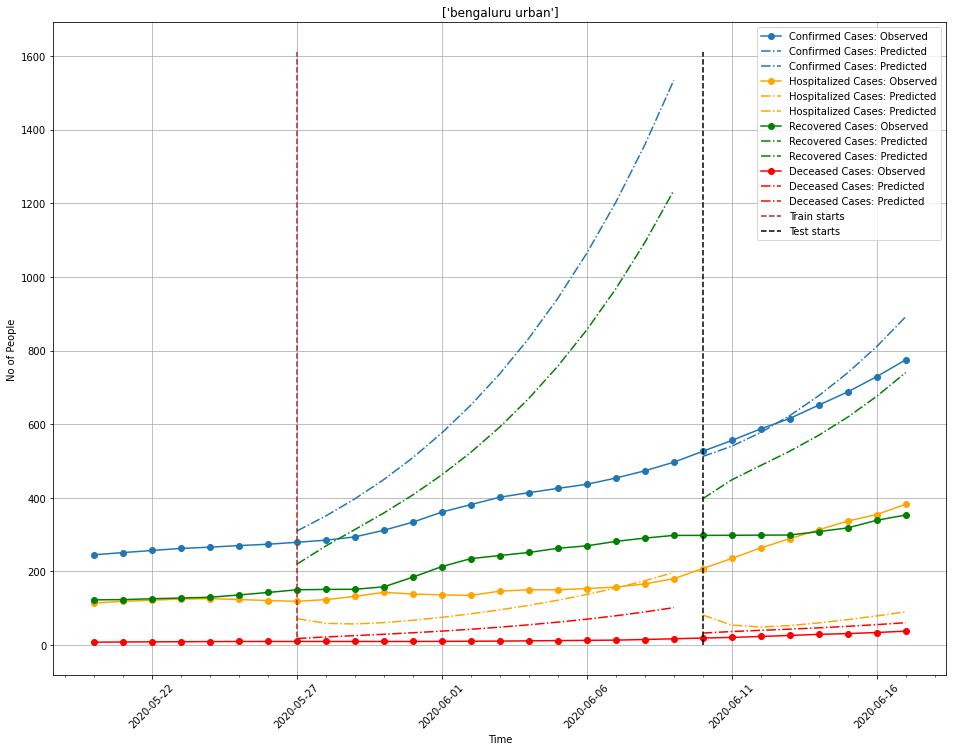

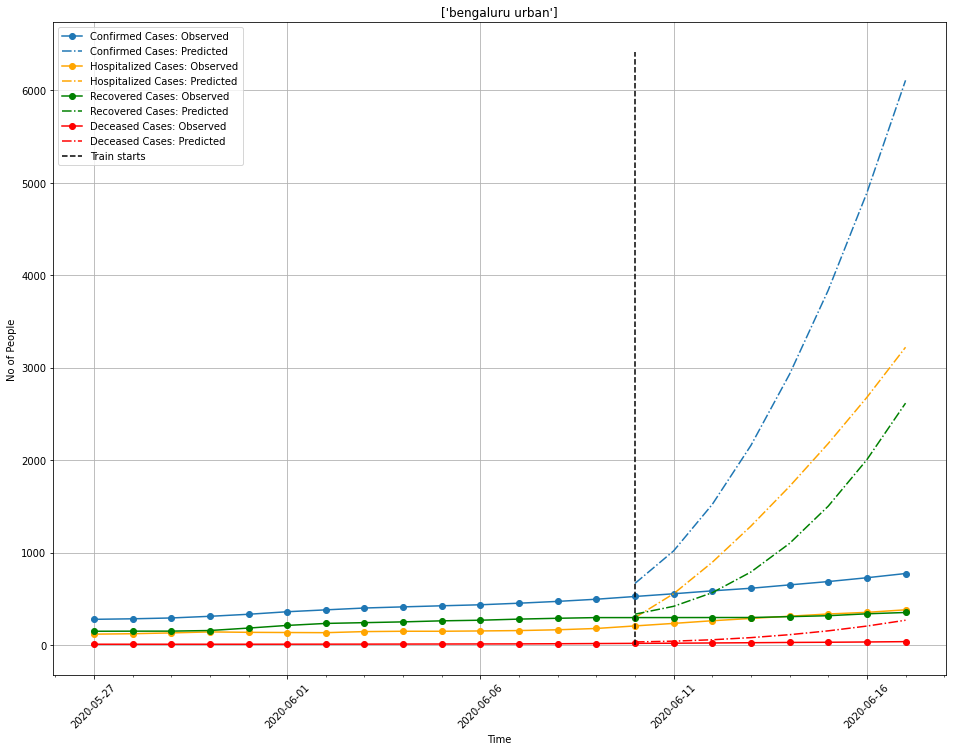

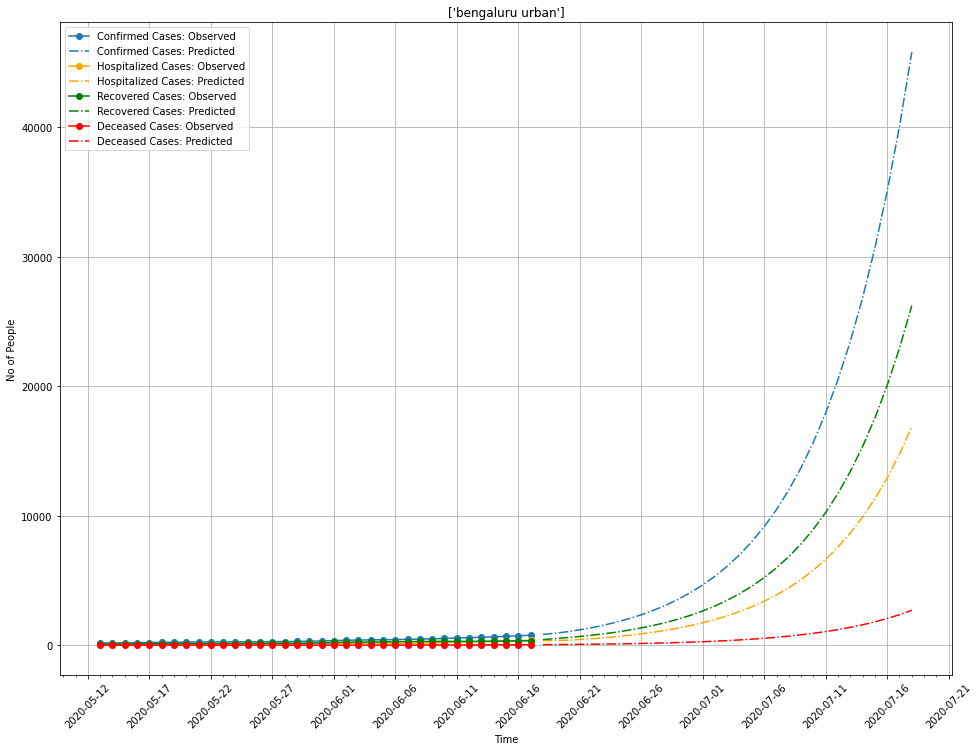

In [8]:
# remove max_evals here, it doesn't work
train_eval_plot_ensemble([region], region_type, 
                         current_day, forecast_length,
                         default_train_config, default_test_config, default_forecast_config,
                         train_period = 14, test_period = 7,
                         max_evals = 100, data_source = 'tracker_district_daily', 
                         mlflow_log = False, mlflow_run_name = "Ensemble testing")